# Ising GNN

## Imports

In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:


def create_graph(X_train, X_test, y_train, y_test, size=190 ,method={'knn' : 10}):
    
    train_data = []
    val_data = []

    # Creating train data in pyG DATA structure
    for i in range((X_train.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_train.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
        
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A

        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])

        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']


        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)
        
        train_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                               y=torch.tensor((y_train.iloc[i]))))

          
    # Creating test data in pyG DATA structure
    for i in range((X_test.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_test.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
                
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A   
        
        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])
            
        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']
          
        
        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)

        val_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                             y=torch.tensor((y_test.iloc[i]))))

    return train_data,val_data

## 2D Ising model simulation by MCMC

### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [5]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    elif string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

In [6]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

In [7]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

In [8]:
# Order Parameter
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

In [9]:
@jit(nopython=True,fastmath=True,nogil=True)
def temporalseries(T,config,iterations,iterations_fluc,fluctuations,J,n):

    temporal_series = np.zeros((fluctuations,n,n))
    mag_data = np.zeros(fluctuations)
    ene_data = np.zeros(fluctuations)
    beta = 1/T
    
    #thermal equilibrium
    for i in range(iterations):
        #if i % 1000000 == 0:
            #print(i/iterations)
        config = MC_met(config,beta, J)
        
    for z in range(fluctuations):
        
        for i in range(iterations_fluc):
            config = MC_met(config,beta,J)

        temporal_series[z] = config
        ene_data[z] = Total_Energy(config, J) 
        mag_data[z] = mag(config)  
        
    return temporal_series, ene_data, mag_data

In [10]:
# Matrix containing all the system states
#@jit(nopython=True,fastmath=True,nogil=True)
def Matrix_X(Temps,config,iterations,J,n, block_size):
    
    fluctuations = 200

    X = np.zeros((len(Temps), int((n//block_size)**4)))#,int(((n)//block_size*block_size)**2)))

    for t in range(len(Temps)):
        print('Models ', t + 1, end="\r",flush=True)
        #if t%100 == 0:
            #print('Models ', t, end="\r",flush=True)
            #print('Temp ',Temps[t], end="\r",flush=True)

        model = temporalseries(Temps[t], config, iterations, n*n, fluctuations, J, n)
        avg_model = average_blocks(model, block_size)

        avg_model_df = pd.DataFrame(avg_model.reshape(fluctuations,avg_model.shape[1]*avg_model.shape[1]))
        #avg_model_df = avg_model_df#.diff(1).dropna()
        corr_matrix = (pd.DataFrame(avg_model_df).corr()).replace(1,0)#*10
        
        X[t,:] = corr_matrix.values.reshape(1,corr_matrix.shape[1]*corr_matrix.shape[1])
    

    return  X



In [11]:
def average_blocks(model, block_size):
    time_series_size = len(model[0][:,0,0]) 
    avg_model = np.zeros((time_series_size,int(len(model[0][1])/block_size),int(len(model[0][1])/block_size)))

    for t in range(time_series_size):
        for i in range(0,(len(model[0][0]) - block_size + 1),block_size):
            for j in range(0, (len(model[0][0]) - block_size + 1),block_size):
                l_0 = block_size
                avg_model[t][i//block_size, j//block_size] = np.mean(model[0][t][i:(i+l_0),j:(j+l_0)])
    return avg_model

In [12]:
@jit(nopython=True, fastmath=True, nogil=True)
def corr_net(temporal_series):
    
    steps = len(temporal_series)
    spins = len(temporal_series[0])**2
    
    temporal_series_linear = temporal_series.reshape((steps*spins ))
    
    corr_array = np.array([0.0])
    xi = np.zeros(steps)
    xj = np.zeros(steps)
    for i in range(spins):
        corr = np.zeros(spins - (i+1))
        for j in range(i+1,spins):
            for n in range(steps):
                xi[n] = temporal_series_linear[i + n*spins]
                xj[n] = temporal_series_linear[j + n*spins]

            diff_i = list()
            diff_j = list()
            for a in range(1, len(xi)):
                value_i = xi[a] - xi[a - 1]
                value_j = xj[a] - xj[a - 1]
                diff_i.append(value_i)
                diff_j.append(value_j)
            corr[j - (i+1)] = float(np.corrcoef(diff_i,diff_j)[0,1])

            #corr[j - (i+1)] = float(np.corrcoef(xi,xj)[0,1])
        corr_array = np.concatenate((corr_array,corr))
        
    return corr_array

## Experimental setup

# TESTAR SE QUALQUER MA
TRIX COM DIST NORMAL SEGUE O PADRÃO

In [13]:
330//23

14

#### fluctuations. increase iterations between time series points

In [14]:
J = 1     # J
n = 330    # Lattice size
iterations = ((n*n)*n)*30    # Iterations to thermal equilibrium
T_1 = np.linspace(1.6,2.21,400)
T_2 = np.linspace(2.21,2.35,800)
#T_3 = np.linspace(2.5,4,100)
Temps = np.hstack((T_1,T_2)).ravel()#,T_3 )).ravel()



In [38]:
config = initial_state(n,"random")


X = Matrix_X(Temps, config,iterations,J,n,23)

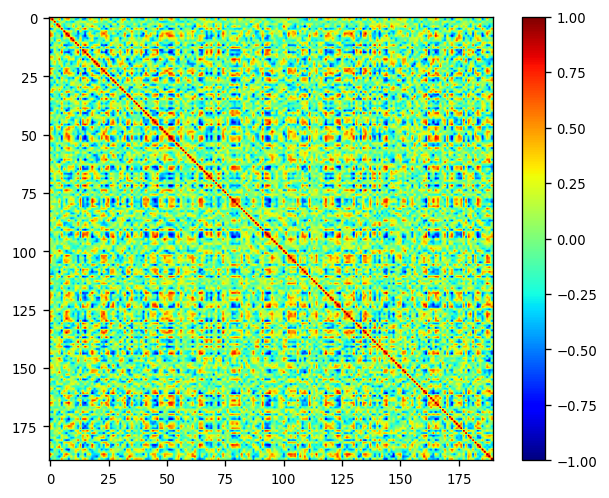

In [24]:
plt.figure(dpi=120)
plt.imshow(reconstruct_symmetric_matrix(190, X[732,:]), cmap='jet',vmin=-1, vmax=1)
plt.colorbar()

In [31]:
X

(1200, 17955)

In [37]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=300)

# ax1.imshow(X[1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet', vmin=-1, vmax=1)#, cmap='Greys')
# ax2.imshow(X[100,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')
# ax3.imshow(X[-1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')

# for i in [ax1,ax2,ax3]:
#     i.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)

# plt.show()

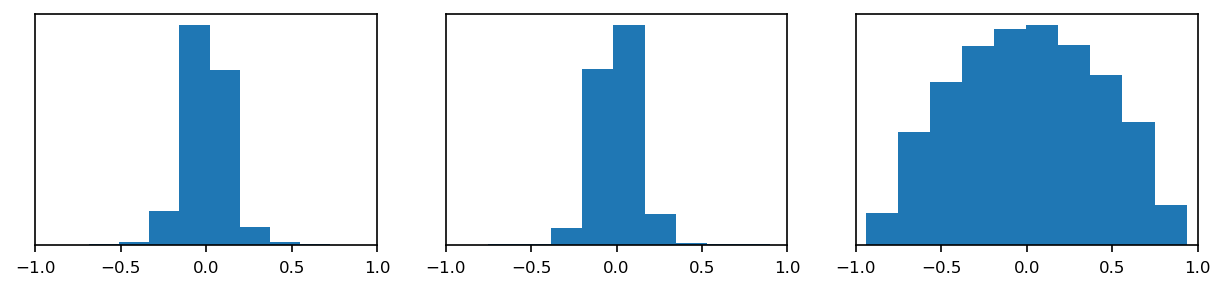

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=150,figsize=(10,2))

ax1.hist(X[0,:])#, cmap='Greys')
ax1.set_xlim(-1,1)
ax2.hist(X[4,:])#, cmap='Greys')
ax2.set_xlim(-1,1)
ax3.hist(X[-1,:])#, cmap='Greys')
ax3.set_xlim(-1,1)

for i in [ax1,ax2,ax3]:
    i.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)

plt.show()

In [39]:
def upper_triangle_array(df):
    #df = df.astype(float)
    matrix = df
    result = matrix[np.triu_indices_from(matrix,1)]
    return result.reshape(1,len(result))

In [40]:
X_aux = X.copy()

In [41]:

X_aux = X_aux[:,:].reshape(X.shape[0],int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1])))[:,3:-3,3:-3]
X_aux.shape

ValueError: cannot reshape array of size 21546000 into shape (1200,133,133)

In [42]:
X = np.zeros((X.shape[0], int((190*190 - 190)/2)))
for i in range(X.shape[0]):
    X[i,:] = upper_triangle_array(X_aux[i,:].reshape(190,190))
    
    

# X = np.zeros(( X.shape[0] , int((int(np.sqrt(X.shape[1]))*int(np.sqrt(X.shape[1])) - int(np.sqrt(X.shape[1])))/2)))
# for i in range(X.shape[0]):
#     X[i,:] = upper_triangle_array(X_aux[i,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))))

ValueError: cannot reshape array of size 17955 into shape (190,190)

In [46]:
X = np.loadtxt('Ising_GNN.txt').reshape(1200,17955)

In [47]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X),pd.DataFrame(Temps),test_size=0.15, shuffle=True, random_state=42)

In [48]:
A = reconstruct_symmetric_matrix(190,X_train.iloc[420,:])#.mean(axis=0))

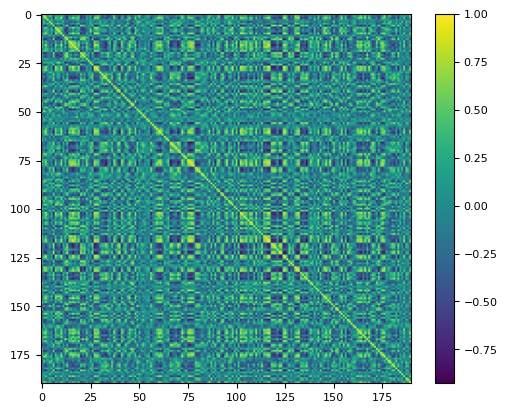

In [49]:
plt.imshow(A)
plt.colorbar()
plt.show()

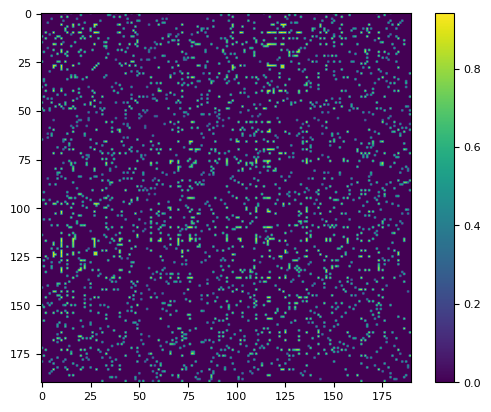

In [50]:
plt.imshow(np.array(compute_KNN_graph(A, 10)))
plt.colorbar()
plt.grid(False)
plt.show()

In [51]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test,size=190)

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST) #,method={'threshold': 0.2})

In [52]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 2762], edge_attr=[2762, 1], y=[1])


In [53]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)


In [54]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool
from torch_geometric.nn import aggr


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.4):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(100,64)
        
        #self.gat1 = GATv2Conv(int(num_features), 148, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*6, 100, heads=1)
        #self.gat3 = GATv2Conv(100*2, 64, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        self.conv2 = ChebConv(128, 128, K=k_order)
        self.conv3 = ChebConv(128, 80, K=k_order)


        self.lin1 = torch.nn.Linear(80, 16)
        self.lin2 = torch.nn.Linear(16, 1)

        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        
        self.pool = global_mean_pool
        
        self.aggregation = aggr.SoftmaxAggregation()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = torch.nn.functional.leaky_relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = torch.nn.functional.leaky_relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        x = torch.nn.functional.leaky_relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
        
        x = self.pool(x, batch)
        #x = self.aggregation(x, batch)
        x1 = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        x2 = self.lin2(x1)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return (x1,x2)

In [55]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)

    return mae, mse, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    loss = nn.MSELoss()
    l1_weight = 0
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)[1]
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (y.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
        
    return mae, mse, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
    return mae,mse, loss_all / len(val_data)


In [56]:
metrics = {"loss_train" : [], "loss_test" : [], "mae_test" : [], "mae_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=.1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
 #model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 150

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_mae, train_mse, train_loss = GCN_train(train_loader,loop)
    test_mae, test_mse, test_loss = GCN_test(val_loader)
    TRAIN_mae, TRAIN_mse, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    #scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['mae_test'].append(test_mae)
    metrics['mae_train'].append(TRAIN_mae)
    
    print('Val MAE {} , Val Loss {}'.format(test_mae, test_loss))
    print('Train MAE {} , Train Loss {}'.format(TRAIN_mae, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/150]: 100%|█████████████████| 32/32 [00:12<00:00,  2.48it/s, loss=1.65]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.8815963975070048 , Val Loss 0.8171478383863966
Train MAE 0.8478949923466563 , Train Loss 0.7615048132690729


Epoch [2/150]: 100%|████████████████| 32/32 [00:11<00:00,  2.90it/s, loss=0.286]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.504535773752208 , Val Loss 0.335699295703105
Train MAE 0.4615145986014357 , Train Loss 0.2918963214930366


Epoch [3/150]: 100%|████████████████| 32/32 [00:09<00:00,  3.52it/s, loss=0.187]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4583757572480538 , Val Loss 0.28738700875126394
Train MAE 0.41919916372455335 , Train Loss 0.24838577468021245


Epoch [4/150]: 100%|████████████████| 32/32 [00:09<00:00,  3.46it/s, loss=0.181]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4496788448534242 , Val Loss 0.27676077336852056
Train MAE 0.4113128510636472 , Train Loss 0.23913681261679706


Epoch [5/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.63it/s, loss=0.173]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4394804423397576 , Val Loss 0.2648712119032805
Train MAE 0.40210996600815435 , Train Loss 0.22876169301715552


Epoch [6/150]: 100%|████████████████| 32/32 [00:09<00:00,  3.52it/s, loss=0.171]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.43549867137688714 , Val Loss 0.2593870673705677
Train MAE 0.39845896083559684 , Train Loss 0.22408051356381062


Epoch [7/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.64it/s, loss=0.164]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.42781741341078894 , Val Loss 0.250383463747274
Train MAE 0.39150868094059976 , Train Loss 0.21627064797223783


Epoch [8/150]: 100%|████████████████| 32/32 [00:09<00:00,  3.44it/s, loss=0.158]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.42238972571284855 , Val Loss 0.24375546380226026
Train MAE 0.386578572505586 , Train Loss 0.21055969163483265


Epoch [9/150]: 100%|████████████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.155]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.41599161479332003 , Val Loss 0.23631358119126086
Train MAE 0.3807757334461303 , Train Loss 0.20411879098882862


Epoch [10/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.83it/s, loss=0.15]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.41031007102216266 , Val Loss 0.22969809286454804
Train MAE 0.3756252373384764 , Train Loss 0.19841209316954894


Epoch [11/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.65it/s, loss=0.147]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.40581968358243486 , Val Loss 0.2242788260914848
Train MAE 0.3715208457215429 , Train Loss 0.1937683973826614


Epoch [12/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.143]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4015496127911904 , Val Loss 0.21915034715526013
Train MAE 0.3676317445343245 , Train Loss 0.18938127808711108


Epoch [13/150]: 100%|███████████████| 32/32 [00:10<00:00,  3.05it/s, loss=0.139]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3949296381515097 , Val Loss 0.21201977484403567
Train MAE 0.36163864422144437 , Train Loss 0.1831949055779214


Epoch [14/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.134]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3892671432536673 , Val Loss 0.20587920532610346
Train MAE 0.35650780627606726 , Train Loss 0.17788977085375318


Epoch [15/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.62it/s, loss=0.13]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38490705421651383 , Val Loss 0.2009945920360931
Train MAE 0.3525518438028402 , Train Loss 0.17369527296692716


Epoch [16/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.67it/s, loss=0.126]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37707646619364604 , Val Loss 0.1932333442036455
Train MAE 0.34550202738516833 , Train Loss 0.1669421419209125


Epoch [17/150]: 100%|███████████████| 32/32 [00:09<00:00,  3.22it/s, loss=0.122]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37204040485373785 , Val Loss 0.18797988527849663
Train MAE 0.3409464232580122 , Train Loss 0.1624188836298737


Epoch [18/150]: 100%|███████████████| 32/32 [00:19<00:00,  1.67it/s, loss=0.121]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3676820920349987 , Val Loss 0.1833753262892565
Train MAE 0.3369823061676924 , Train Loss 0.1584665429358389


Epoch [19/150]: 100%|███████████████| 32/32 [00:09<00:00,  3.32it/s, loss=0.116]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3642225497075417 , Val Loss 0.1795935887307779
Train MAE 0.33383503014971705 , Train Loss 0.15524465482608946


Epoch [20/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.116]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3603322737523415 , Val Loss 0.1755189180266623
Train MAE 0.33030071955339685 , Train Loss 0.1517559922208973


Epoch [21/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.63it/s, loss=0.11]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3545271025540264 , Val Loss 0.1699746174307519
Train MAE 0.32505324603973423 , Train Loss 0.1469553600923688


Epoch [22/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.67it/s, loss=0.108]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.34893687431433124 , Val Loss 0.16471518063957294
Train MAE 0.32000804035693065 , Train Loss 0.14240379941229728


Epoch [23/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.78it/s, loss=0.105]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3438316951076319 , Val Loss 0.15993164110409958
Train MAE 0.31539852006764774 , Train Loss 0.13827347685309016


Epoch [24/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.86it/s, loss=0.102]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3404644369855687 , Val Loss 0.15657296170169022
Train MAE 0.3123382898850252 , Train Loss 0.13540980494489857


Epoch [25/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.86it/s, loss=0.102]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33935711315358663 , Val Loss 0.15499835907238674
Train MAE 0.31131321719384214 , Train Loss 0.13413670320136875


Epoch [26/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.81it/s, loss=0.0968]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33278925416620225 , Val Loss 0.14930384460887278
Train MAE 0.30538145686071605 , Train Loss 0.12918063837523555


Epoch [27/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.93it/s, loss=0.0952]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.329498740014947 , Val Loss 0.14616875096386744
Train MAE 0.30239678896901784 , Train Loss 0.12650996759241703


Epoch [28/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.74it/s, loss=0.0934]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3246912879957222 , Val Loss 0.14195657984003243
Train MAE 0.2980553666914045 , Train Loss 0.12287453266919827


Epoch [29/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.79it/s, loss=0.0897]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3193175477994942 , Val Loss 0.1373934717780887
Train MAE 0.29319154277752546 , Train Loss 0.11892097081039466


Epoch [30/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.72it/s, loss=0.0887]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3172868254992826 , Val Loss 0.13535939787642773
Train MAE 0.2913639911320524 , Train Loss 0.1172218077323016


Epoch [31/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.81it/s, loss=0.0861]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3148791107643146 , Val Loss 0.13308106933819266
Train MAE 0.2892032003145543 , Train Loss 0.1153034841897441


Epoch [32/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.74it/s, loss=0.0822]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.30792491203017996 , Val Loss 0.12757548875316488
Train MAE 0.2829024089739292 , Train Loss 0.11050046112607508


Epoch [33/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.0827]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3043800178382261 , Val Loss 0.1245851761097179
Train MAE 0.2797061696193655 , Train Loss 0.10794051777498395


Epoch [34/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.65it/s, loss=0.0794]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.301895773730026 , Val Loss 0.12239006925843164
Train MAE 0.2774741039608903 , Train Loss 0.10608753100329754


Epoch [35/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.82it/s, loss=0.0785]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2979069587138093 , Val Loss 0.11917641642501925
Train MAE 0.2738780283512718 , Train Loss 0.1033280944707347


Epoch [36/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.69it/s, loss=0.0775]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.29429332977004813 , Val Loss 0.11627357403307946
Train MAE 0.27061885221854604 , Train Loss 0.10084055545283299


Epoch [37/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.69it/s, loss=0.0747]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.29087870351607237 , Val Loss 0.11355583725372627
Train MAE 0.26754419815829444 , Train Loss 0.09851582228553062


Epoch [38/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.59it/s, loss=0.0736]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2879324220829669 , Val Loss 0.1111959631856081
Train MAE 0.26489432957181036 , Train Loss 0.09650781140023587


Epoch [39/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.72it/s, loss=0.071]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.28339285286401344 , Val Loss 0.1078166180468846
Train MAE 0.2607903605840146 , Train Loss 0.09358576953995462


Epoch [40/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.04it/s, loss=0.0698]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2802691250920425 , Val Loss 0.10541803322447707
Train MAE 0.25797686848223306 , Train Loss 0.0915393717733084


Epoch [41/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.02it/s, loss=0.0682]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27748627498545214 , Val Loss 0.10327298662848819
Train MAE 0.2554680469902426 , Train Loss 0.08971588430451412


Epoch [42/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.89it/s, loss=0.0661]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.276020574253115 , Val Loss 0.10198463149599775
Train MAE 0.25417976369428485 , Train Loss 0.08865727463773652


Epoch [43/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.99it/s, loss=0.0642]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2711728390865653 , Val Loss 0.0986046593920643
Train MAE 0.24978346695395184 , Train Loss 0.08572913741364199


Epoch [44/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.97it/s, loss=0.0641]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.26827745538418124 , Val Loss 0.09648659011250958
Train MAE 0.24718183651823092 , Train Loss 0.08392644720334633


Epoch [45/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.37it/s, loss=0.0618]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.26443032127086946 , Val Loss 0.09382940651615727
Train MAE 0.243716831939058 , Train Loss 0.08164005516206517


Epoch [46/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.83it/s, loss=0.0606]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.261513003059208 , Val Loss 0.09176529672614984
Train MAE 0.24108439533991535 , Train Loss 0.07987697887070039


Epoch [47/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.94it/s, loss=0.0589]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2594737890839374 , Val Loss 0.09025728403321914
Train MAE 0.23925535296959466 , Train Loss 0.07861009611218583


Epoch [48/150]: 100%|██████████████| 32/32 [00:14<00:00,  2.16it/s, loss=0.0592]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25639309189185133 , Val Loss 0.08815711162002218
Train MAE 0.23648244672319427 , Train Loss 0.0768146122787513


Epoch [49/150]: 100%|██████████████| 32/32 [00:10<00:00,  3.07it/s, loss=0.0567]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2522362606538464 , Val Loss 0.08547138597351578
Train MAE 0.2327388213596522 , Train Loss 0.07449246954684165


Epoch [50/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.36it/s, loss=0.0559]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2486381415009296 , Val Loss 0.08315576781555542
Train MAE 0.22951566520437167 , Train Loss 0.07250037012146969


Epoch [51/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.0546]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24651200143626625 , Val Loss 0.08170086895669455
Train MAE 0.22760191036009464 , Train Loss 0.07127680519924444


Epoch [52/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.37it/s, loss=0.0532]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2447886609514352 , Val Loss 0.08049159204361887
Train MAE 0.22605230800808487 , Train Loss 0.07026906121595233


Epoch [53/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.98it/s, loss=0.0525]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24084889459740416 , Val Loss 0.07807691818923357
Train MAE 0.22251629352373378 , Train Loss 0.06818546774048431


Epoch [54/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.85it/s, loss=0.0517]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2387014822972943 , Val Loss 0.07667916720671807
Train MAE 0.2205838153891118 , Train Loss 0.0670059346393043


Epoch [55/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.34it/s, loss=0.0497]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23477109175388644 , Val Loss 0.07434871986850138
Train MAE 0.21706576288552779 , Train Loss 0.0649936158283084


Epoch [56/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.04it/s, loss=0.0492]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23320137959186862 , Val Loss 0.07330953920155076
Train MAE 0.2156494443811161 , Train Loss 0.06412939167782372


Epoch [57/150]: 100%|██████████████| 32/32 [00:10<00:00,  2.99it/s, loss=0.0485]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2334346758917909 , Val Loss 0.07322324557733534
Train MAE 0.2158608135620271 , Train Loss 0.06411963281970398


Epoch [58/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.24it/s, loss=0.0486]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22832134466831513 , Val Loss 0.0703590996871908
Train MAE 0.2112707554685523 , Train Loss 0.06162558894823579


Epoch [59/150]: 100%|██████████████| 32/32 [00:10<00:00,  3.17it/s, loss=0.0466]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22552490666307967 , Val Loss 0.06873311669658304
Train MAE 0.2087595468158658 , Train Loss 0.06023511239418797


Epoch [60/150]: 100%|███████████████| 32/32 [00:10<00:00,  3.13it/s, loss=0.046]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22326623409283902 , Val Loss 0.06740696704328034
Train MAE 0.20673545161717843 , Train Loss 0.05911211399178879


Epoch [61/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.88it/s, loss=0.0451]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22095105193680603 , Val Loss 0.06606959278781106
Train MAE 0.2046606313874855 , Train Loss 0.05797769382011657


Epoch [62/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.74it/s, loss=0.0433]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21730068228110302 , Val Loss 0.06409396399534191
Train MAE 0.20138772307304711 , Train Loss 0.05627425726430089


Epoch [63/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.95it/s, loss=0.0437]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21763235538495326 , Val Loss 0.06409234789850113
Train MAE 0.20169540132729827 , Train Loss 0.05633047689117637


Epoch [64/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.0423]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21368277214592774 , Val Loss 0.06201944082193146
Train MAE 0.19817979549553336 , Train Loss 0.05453731312471278


Epoch [65/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.87it/s, loss=0.0428]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21255880338575522 , Val Loss 0.0613259583455753
Train MAE 0.1971794855401351 , Train Loss 0.053971435392604156


Epoch [66/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.97it/s, loss=0.0409]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2095069038466554 , Val Loss 0.05973260996709844
Train MAE 0.19449240181519667 , Train Loss 0.052604966654497036


Epoch [67/150]: 100%|██████████████| 32/32 [00:13<00:00,  2.43it/s, loss=0.0411]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20660168868925252 , Val Loss 0.058236537853614816
Train MAE 0.191955745097423 , Train Loss 0.05132200263586699


Epoch [68/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.06it/s, loss=0.0407]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20461585332247362 , Val Loss 0.057185190069210676
Train MAE 0.19023415728501278 , Train Loss 0.05043653324246407


Epoch [69/150]: 100%|██████████████| 32/32 [00:08<00:00,  4.00it/s, loss=0.0384]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20091722708408663 , Val Loss 0.055380262683505065
Train MAE 0.18703468996052458 , Train Loss 0.04887806987937759


Epoch [70/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.0379]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19879273649016432 , Val Loss 0.05430726705123795
Train MAE 0.18521308457238742 , Train Loss 0.04797076562456056


Epoch [71/150]: 100%|██████████████| 32/32 [00:11<00:00,  2.83it/s, loss=0.0373]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1985119376840798 , Val Loss 0.05406310158360712
Train MAE 0.18498906657049263 , Train Loss 0.04780063434850936


Epoch [72/150]: 100%|██████████████| 32/32 [00:11<00:00,  2.68it/s, loss=0.0364]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19471165348383532 , Val Loss 0.05228414314527375
Train MAE 0.18174203371976425 , Train Loss 0.046259405580805796


Epoch [73/150]: 100%|██████████████| 32/32 [00:13<00:00,  2.37it/s, loss=0.0358]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19341362525316821 , Val Loss 0.05161298463913732
Train MAE 0.18065245580573472 , Train Loss 0.045706117065513835


Epoch [74/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.48it/s, loss=0.0354]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19222431920594055 , Val Loss 0.05099967069527338
Train MAE 0.179661773637271 , Train Loss 0.04520295487315047


Epoch [75/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.88it/s, loss=0.0343]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18861405726233535 , Val Loss 0.04936885255805868
Train MAE 0.1766319706106388 , Train Loss 0.04379592593394074


Epoch [76/150]: 100%|██████████████| 32/32 [00:15<00:00,  2.09it/s, loss=0.0338]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1879113489650297 , Val Loss 0.04898096591831644
Train MAE 0.17606106633702598 , Train Loss 0.0434919265117131


Epoch [77/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.84it/s, loss=0.0338]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18563153289383727 , Val Loss 0.04794286681792275
Train MAE 0.17415131855882535 , Train Loss 0.042608038394474516


Epoch [78/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.05it/s, loss=0.0329]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1838498089971749 , Val Loss 0.04712714886293302
Train MAE 0.1726624180961503 , Train Loss 0.04191965105779031


Epoch [79/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.95it/s, loss=0.0329]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18236124836667722 , Val Loss 0.046428497874790586
Train MAE 0.17142096529773335 , Train Loss 0.04133749196634573


Epoch [80/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.76it/s, loss=0.0317]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18041025456386484 , Val Loss 0.0455476482264607
Train MAE 0.16978121263959778 , Train Loss 0.04059052690863609


Epoch [81/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.89it/s, loss=0.0315]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17727412174076845 , Val Loss 0.04420590973796708
Train MAE 0.16717646736765823 , Train Loss 0.03943378373103983


Epoch [82/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.88it/s, loss=0.0316]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17785928371811255 , Val Loss 0.04436679555590975
Train MAE 0.1677096255657988 , Train Loss 0.03961227331675735


Epoch [83/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0305]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17532090931823263 , Val Loss 0.043281354688742606
Train MAE 0.16561959233622858 , Train Loss 0.03868269921810019


Epoch [84/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.79it/s, loss=0.0303]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1722358715834592 , Val Loss 0.0419863685004859
Train MAE 0.1630823856981821 , Train Loss 0.037564282090056175


Epoch [85/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.47it/s, loss=0.0297]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1715988727711016 , Val Loss 0.041667589640398246
Train MAE 0.16259334710790585 , Train Loss 0.03731325392921766


Epoch [86/150]: 100%|████████████████| 32/32 [00:08<00:00,  3.98it/s, loss=0.03]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1705106839411591 , Val Loss 0.041173555627595865
Train MAE 0.16173218121218436 , Train Loss 0.0369055929283301


Epoch [87/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.99it/s, loss=0.0288]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.168366157830404 , Val Loss 0.04026817673678554
Train MAE 0.1599998721334186 , Train Loss 0.03613158984511506


Epoch [88/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.00it/s, loss=0.0276]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1663724676885785 , Val Loss 0.03942164186799901
Train MAE 0.15837915382825052 , Train Loss 0.03540911198977162


Epoch [89/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.06it/s, loss=0.0283]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16429585515589484 , Val Loss 0.03855314845636089
Train MAE 0.156712667238202 , Train Loss 0.03466900668892206


Epoch [90/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.90it/s, loss=0.0278]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16238849526442722 , Val Loss 0.03774380511648461
Train MAE 0.15517644268735506 , Train Loss 0.03398003515367414


Epoch [91/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.90it/s, loss=0.0276]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1621499356209997 , Val Loss 0.03758917313870048
Train MAE 0.15502794508187875 , Train Loss 0.033870217890716064


Epoch [92/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.13it/s, loss=0.0273]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16222163012985977 , Val Loss 0.037554879523695996
Train MAE 0.155149080490018 , Train Loss 0.03386791764813311


Epoch [93/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.14it/s, loss=0.0271]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16114977106151906 , Val Loss 0.03708741299240425
Train MAE 0.1543316901302981 , Train Loss 0.03348323662637496


Epoch [94/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.90it/s, loss=0.0262]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15775763888290492 , Val Loss 0.035747653680663107
Train MAE 0.1515915827210586 , Train Loss 0.03231928764897234


Epoch [95/150]: 100%|███████████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.026]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1556991947836194 , Val Loss 0.03492453020658554
Train MAE 0.14995970313967538 , Train Loss 0.03161441469747646


Epoch [96/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.01it/s, loss=0.0252]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15464112032123548 , Val Loss 0.03445990832324747
Train MAE 0.14909516999220512 , Train Loss 0.031226392550503506


Epoch [97/150]: 100%|███████████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.026]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15311715102355966 , Val Loss 0.033811584877592005
Train MAE 0.14782317222298838 , Train Loss 0.03067623549962745


Epoch [98/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.71it/s, loss=0.0253]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1528013646174706 , Val Loss 0.03362844860398203
Train MAE 0.14756635987273242 , Train Loss 0.0305362860361735


Epoch [99/150]: 100%|███████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.025]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15237139392918053 , Val Loss 0.03340380639683897
Train MAE 0.14721987785543234 , Train Loss 0.030361219502839387


Epoch [100/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.02it/s, loss=0.024]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14919584041026862 , Val Loss 0.03214391220312065
Train MAE 0.1445114041114822 , Train Loss 0.02926707180107341


Epoch [101/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.0243]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.150226714992581 , Val Loss 0.03247370159347156
Train MAE 0.1454037180640919 , Train Loss 0.0295823086856627


Epoch [102/150]: 100%|█████████████| 32/32 [00:09<00:00,  3.52it/s, loss=0.0234]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14784143546099204 , Val Loss 0.031525796059458835
Train MAE 0.14336570482515767 , Train Loss 0.028764056677327437


Epoch [103/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.83it/s, loss=0.0237]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1472007709629808 , Val Loss 0.03123623964808707
Train MAE 0.1428364379561007 , Train Loss 0.02852929378403168


Epoch [104/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.73it/s, loss=0.0236]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14731618906132862 , Val Loss 0.031229147931042513
Train MAE 0.14296205771328366 , Train Loss 0.02854501664930699


Epoch [105/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.023]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14502014809418304 , Val Loss 0.030328991458940715
Train MAE 0.14099940566070945 , Train Loss 0.027765690871313507


Epoch [106/150]: 100%|██████████████| 32/32 [00:09<00:00,  3.33it/s, loss=0.023]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14377024317233614 , Val Loss 0.029805253589427455
Train MAE 0.13990491914637002 , Train Loss 0.02732100727803567


Epoch [107/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.86it/s, loss=0.0217]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14312955485325074 , Val Loss 0.02952135722994432
Train MAE 0.13935313468145966 , Train Loss 0.027087861350646204


Epoch [108/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.65it/s, loss=0.0223]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1419751888919666 , Val Loss 0.029033552972333294
Train MAE 0.13832609289430597 , Train Loss 0.026674343988883728


Epoch [109/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.86it/s, loss=0.0225]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14210699346205607 , Val Loss 0.029040951442397676
Train MAE 0.13846596348957171 , Train Loss 0.02669950701734599


Epoch [110/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.91it/s, loss=0.0224]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14117983195391975 , Val Loss 0.0286509610300025
Train MAE 0.1376519539587002 , Train Loss 0.026371369781155212


Epoch [111/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.80it/s, loss=0.0216]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14009371463545112 , Val Loss 0.02820609148182061
Train MAE 0.13670233253591557 , Train Loss 0.02599432189382759


Epoch [112/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.021]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13988356537164265 , Val Loss 0.02809151824773153
Train MAE 0.13653904570470748 , Train Loss 0.025909103759947944


Epoch [113/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.79it/s, loss=0.0209]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13727908192018928 , Val Loss 0.027093102131002984
Train MAE 0.1342548024688928 , Train Loss 0.02504091013003798


Epoch [114/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.75it/s, loss=0.0211]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1380447779748938 , Val Loss 0.027349729943770187
Train MAE 0.13496921803329104 , Train Loss 0.025284007900193625


Epoch [115/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.06it/s, loss=0.0209]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13870064672235796 , Val Loss 0.02755525089701294
Train MAE 0.13559018013695237 , Train Loss 0.025484086507383513


Epoch [116/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.13it/s, loss=0.0202]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13510935440247465 , Val Loss 0.02619544377934599
Train MAE 0.1324009700013714 , Train Loss 0.024293020857023256


Epoch [117/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.07it/s, loss=0.0206]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1359840493142561 , Val Loss 0.02649596383706978
Train MAE 0.13322059088289753 , Train Loss 0.02457475717015126


Epoch [118/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.0208]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.135181612535116 , Val Loss 0.026173423491705625
Train MAE 0.13253271341320472 , Train Loss 0.024303334169820244


Epoch [119/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.0202]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1332963321908947 , Val Loss 0.025444726983927683
Train MAE 0.13085291283565892 , Train Loss 0.023672020647163484


Epoch [120/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.01it/s, loss=0.0201]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13308157400667364 , Val Loss 0.025341284851429516
Train MAE 0.13068308693885186 , Train Loss 0.023592977766312806


Epoch [121/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.95it/s, loss=0.0204]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13308425489114087 , Val Loss 0.025320492500683637
Train MAE 0.1307342297395866 , Train Loss 0.023589583259879376


Epoch [122/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.98it/s, loss=0.0195]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1323873679808083 , Val Loss 0.025043286479855296
Train MAE 0.1301429556370577 , Train Loss 0.02335617393985683


Epoch [123/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.84it/s, loss=0.0198]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13200478033601934 , Val Loss 0.02488465809848953
Train MAE 0.12983979436217377 , Train Loss 0.02322903068772718


Epoch [124/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.84it/s, loss=0.0196]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13191409070126972 , Val Loss 0.024835419592213585
Train MAE 0.12981575820640617 , Train Loss 0.02320064219335715


Epoch [125/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.89it/s, loss=0.0201]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.13080638722955878 , Val Loss 0.024417057794324945
Train MAE 0.12885388728677463 , Train Loss 0.02284247875213623


Epoch [126/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.81it/s, loss=0.0187]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12974566164658827 , Val Loss 0.024022946346377062
Train MAE 0.1279489374587376 , Train Loss 0.022506215408736586


Epoch [127/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.90it/s, loss=0.0187]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1285551746811051 , Val Loss 0.02359039568980942
Train MAE 0.12694794000483303 , Train Loss 0.022136838580755627


Epoch [128/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.83it/s, loss=0.0196]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12871507943757507 , Val Loss 0.023629981462778143
Train MAE 0.1271250857234836 , Train Loss 0.02218381260686061


Epoch [129/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.91it/s, loss=0.0181]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1268439103367864 , Val Loss 0.022950703759872543
Train MAE 0.12548598138708253 , Train Loss 0.02159515462231402


Epoch [130/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.69it/s, loss=0.0185]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12860873894765507 , Val Loss 0.023566731343736554
Train MAE 0.1271265526359418 , Train Loss 0.022152598538235122


Epoch [131/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.62it/s, loss=0.0187]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12587208177012923 , Val Loss 0.022578047736894608
Train MAE 0.12466776362447061 , Train Loss 0.021285630090563903


Epoch [132/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.88it/s, loss=0.018]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12617925637781582 , Val Loss 0.02267457798947766
Train MAE 0.12498110199832996 , Train Loss 0.02138164955757412


Epoch [133/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.95it/s, loss=0.019]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12618225118007886 , Val Loss 0.022661827743147317
Train MAE 0.12501505612061706 , Train Loss 0.02138107948589559


Epoch [134/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.019]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12628452082958447 , Val Loss 0.0226852392315992
Train MAE 0.125149146823693 , Train Loss 0.021412863217148127


Epoch [135/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.05it/s, loss=0.0181]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1256962562416903 , Val Loss 0.022466292517089592
Train MAE 0.1246442241906154 , Train Loss 0.021227809217046287


Epoch [136/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.04it/s, loss=0.018]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1243023327471394 , Val Loss 0.021965613113956
Train MAE 0.12339162053582012 , Train Loss 0.02079154567829534


Epoch [137/150]: 100%|██████████████| 32/32 [00:07<00:00,  4.13it/s, loss=0.018]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12476909142218483 , Val Loss 0.022115560395993977
Train MAE 0.12385459776910575 , Train Loss 0.020934552027314316


Epoch [138/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.97it/s, loss=0.0182]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12330742915165305 , Val Loss 0.021598269806530526
Train MAE 0.12255037006475639 , Train Loss 0.020484238234805125


Epoch [139/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.92it/s, loss=0.0175]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12375105601035011 , Val Loss 0.02174050261975632
Train MAE 0.1229905057463174 , Train Loss 0.02062022755397301


Epoch [140/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.97it/s, loss=0.0179]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12349362818548201 , Val Loss 0.021643282975552815
Train MAE 0.12280257604200144 , Train Loss 0.020543069428965156


Epoch [141/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.05it/s, loss=0.0174]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12309506185997644 , Val Loss 0.02149865751568743
Train MAE 0.12248059186779663 , Train Loss 0.020423376684387526


Epoch [142/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.04it/s, loss=0.0174]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12098796555272237 , Val Loss 0.02077768052486925
Train MAE 0.1205957920200502 , Train Loss 0.019790369440235343


Epoch [143/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.0179]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12122328733939093 , Val Loss 0.020849536461786833
Train MAE 0.12083509947959613 , Train Loss 0.019861443852092705


Epoch [144/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.02it/s, loss=0.0176]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12137450242037973 , Val Loss 0.020892129871905734
Train MAE 0.12101037102110458 , Train Loss 0.01990864678632979


Epoch [145/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.04it/s, loss=0.0167]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12114853127792877 , Val Loss 0.02080705577028539
Train MAE 0.12082720653206908 , Train Loss 0.019840003856841256


Epoch [146/150]: 100%|█████████████| 32/32 [00:07<00:00,  4.01it/s, loss=0.0175]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.12067306436428164 , Val Loss 0.020639935414725287
Train MAE 0.12041793460364401 , Train Loss 0.019699017535529884


Epoch [147/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.82it/s, loss=0.0167]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.11985646243547521 , Val Loss 0.020359810149949847
Train MAE 0.11969090890871044 , Train Loss 0.019457889954541244


Epoch [148/150]: 100%|██████████████| 32/32 [00:08<00:00,  3.94it/s, loss=0.017]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.11928764930032333 , Val Loss 0.020157815642464053
Train MAE 0.11917129654937565 , Train Loss 0.01928583742941127


Epoch [149/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.97it/s, loss=0.0168]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.11951911475049004 , Val Loss 0.02022704231890076
Train MAE 0.11940853171943827 , Train Loss 0.01935379237813108


Epoch [150/150]: 100%|█████████████| 32/32 [00:08<00:00,  3.99it/s, loss=0.0172]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.11809761806325092 , Val Loss 0.019733996090018184
Train MAE 0.11804441578324715 , Train Loss 0.0189210511232708


In [22]:
model.eval()


GCN(
  (conv1): ChebConv(190, 128, K=3, normalization=sym)
  (conv2): ChebConv(128, 128, K=3, normalization=sym)
  (conv3): ChebConv(128, 80, K=3, normalization=sym)
  (lin1): Linear(in_features=80, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
  (aggregation): SoftmaxAggregation(learn=False)
)

In [56]:
y_pred_aux = np.array([])
y_test_aux = []
for y_i in val_loader:
    y_pred_aux = np.concatenate((y_pred_aux, (model(y_i))[1].detach().numpy().ravel()) )
    y_test_aux.append(y_i.y.numpy()[0])


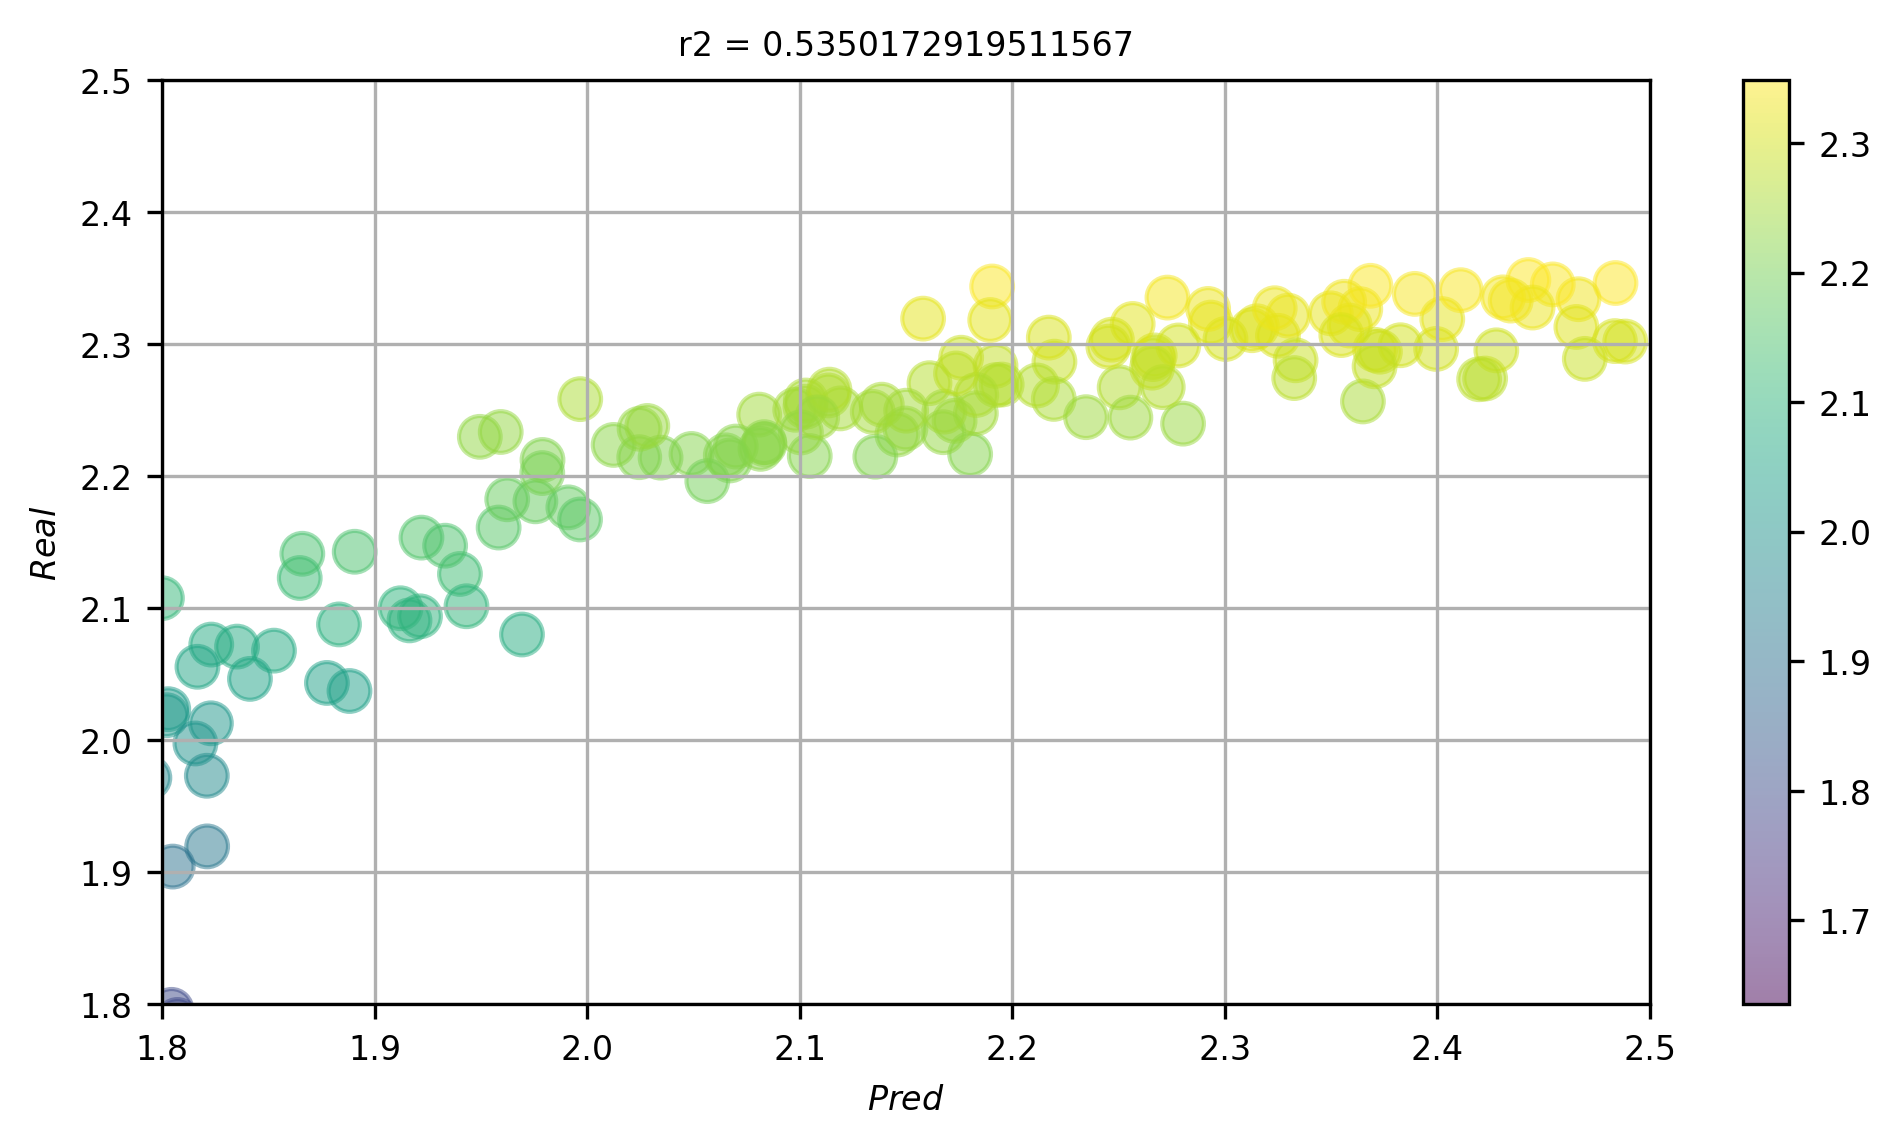

In [57]:

# Plot first and second principal component.

plt.figure(figsize=(8,4),dpi=300)

plt.scatter(pd.DataFrame(y_pred_aux),pd.DataFrame(y_test.values),
            c=y_test, cmap='viridis', alpha=0.5, s=100)
plt.title('r2 = {}'.format(r2_score(y_test, y_pred_aux)))
plt.colorbar()
plt.ylabel(r'$Real$')
plt.xlabel(r'$Pred$')
plt.xlim(1.8,2.5)
plt.ylim(1.8,2.5)
plt.grid()

plt.show()

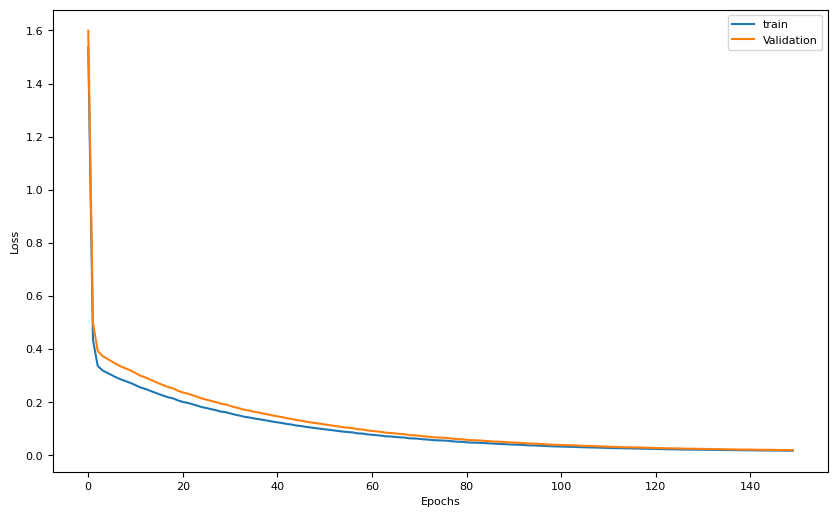

In [58]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
#plt.xlim(80,100)
ax.legend()
plt.show()

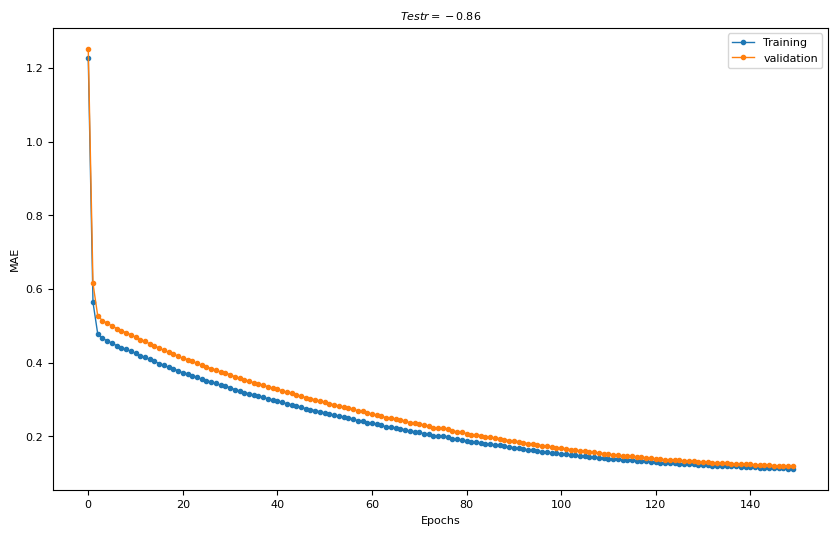

In [59]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['mae_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['mae_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('MAE')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['mae_test'])), metrics['mae_test'])[0][1]))
ax.legend()
#plt.ylim(0,3)
plt.show()

## Testing on experimental data

In [227]:
df, phenotypic = import_data(fisher=False)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['DX']), how='left')
df['DX'] = df['DX'].replace( {1: 0 ,2 : 1, 3: 1})

df = ((df.reset_index()).drop(columns=['Institution', 'Subject', 'Run'])).dropna(subset=[str(x) for x in range(0,17955)])
df = df.dropna(axis=0, subset=['Age'])

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

#df = df[df['DX'] == 0]


# Labels
y = df.Age
#y = (df.Age).apply(lambda x: int(x)) # discretize


# Remove from Fisher-space
X_fmri = np.tanh(df.iloc[:,:-2])


In [228]:
# FOR HEAD MOTION
merged_df,merged_phenotypic  = read_motion()
merged_df = merged_df.set_index(['Institution', 'Subject', 'Run'])
merged_phenotypic = merged_phenotypic.set_index(['Institution', 'Subject', 'Run'])
common_indices = merged_df.index.intersection(merged_phenotypic.index)
merged_phenotypic = merged_phenotypic.loc[common_indices,:]
merged_df = merged_df.reset_index()
merged_phenotypic = merged_phenotypic.reset_index()

X_fmri = merged_df.iloc[:,14:]
y = merged_df['Max Motion (mm)']
y = merged_phenotypic['Age']

/Users/rodrigo/Post-Grad/CC400/Repo/utils.py:347: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


In [229]:
df['DX'].value_counts()

0    1980
1     376
Name: DX, dtype: int64

In [230]:
#X_fmri = pd.DataFrame(np.random.normal(0, 0.25, size= (757, 17955)))

In [231]:
#from sklearn.model_selection import train_test_split

# Split train and validation set
#X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95, shuffle=True, random_state=42)

In [232]:
A = reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))

In [233]:
train_data, val_data = create_graph(X_train, X_fmri, y, y,method={'knn_group' : compute_KNN_graph(A, 10)})#, method={'threshold': 0.8})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

In [234]:
y_pred_aux_age = []
for y_i in val_loader:
    y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0]) 


#### Age decrease complexity https://www.frontiersin.org/articles/10.3389/fnins.2020.00700/full

In [235]:
my_dict_age = {}
for i in range(len(y.values)):
    my_dict_age[y.values[i]] = y_pred_aux_age[i]

In [236]:
y = pd.DataFrame(y)
y['y_pred'] = y_pred_aux_age
y = y.dropna()

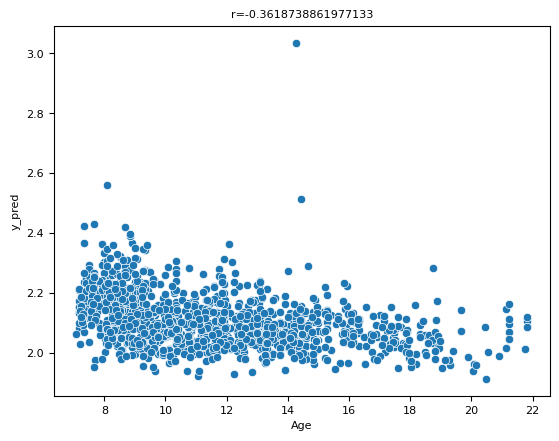

In [237]:
#sns.boxplot(y_test, x='Age', y='y_pred')

#sns.scatterplot(y, x='Max Motion (mm)', y='y_pred') 
#plt.title('r={}'.format(np.corrcoef([y['Max Motion (mm)'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Max Motion (mm)'].values, y_test['y_pred'].values)))

sns.scatterplot(y, x='Age', y='y_pred') 
plt.title('r={}'.format(np.corrcoef([y['Age'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Age'].values, y_test['y_pred'].values)))

plt.show()

In [240]:
results = merged_df[['Institution','Subject', 'Run']]
results['Age'] = y_pred_aux_age

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_1880/591760499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Age'] = y_pred_aux_age


In [241]:
result.to_csv()

,Institution,Subject,Run,Age
0,WashU,15002,1,2.211151
1,WashU,15002,2,2.143991
2,WashU,15002,3,2.150293
3,WashU,15002,4,2.083379
4,WashU,15002,5,2.211803
...,...,...,...,...
1177,KKI,8337695,1,2.088256
1178,KKI,8432725,1,2.058080
1179,KKI,8628223,1,1.986197
1180,KKI,8658218,1,2.052589


### DX

In [ ]:
df_aux = df[df['DX'] == 0]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_0 = []
for y_i in val_loader:
    y_pred_aux_0.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
df_aux = df[df['DX'] == 1]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_1 = []
for y_i in val_loader:
    y_pred_aux_1.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
my_dict = {'1': y_pred_aux_1, '0' : y_pred_aux_0}


In [ ]:
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
#plt.ylim(1.8,2.1)
plt.show()

In [189]:
X.shape

(1200, 17955)

In [190]:
np.savetxt('Ising_GNN.txt', X.reshape(1200*17955))